In [2]:
!pip install catboost xgboost scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# === Load & Prepare Data ===
df = pd.read_csv("/content/drive/MyDrive/Network Maintenace - With & without maintenace/encoded-data/No-main-encoded-dataset-2017-2020/df_encoded_no-main_2017_2020.csv")
df = df.dropna().drop_duplicates()

X = df.drop(columns=['IRI_mean_y'])
y = df[['IRI_mean_y']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_val_scaled = scaler_x.transform(X_val)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


In [4]:
# === Evaluation Function ===
def evaluate_model(model, name):
    # Predictions and true values
    y_pred = scaler_y.inverse_transform(model.predict(X_test_scaled).reshape(-1, 1))
    y_true = y_test.values

    # Metrics calculation
    n = len(y_true)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    mae = np.mean(np.abs(y_true - y_pred))
    epsilon = 1e-10
    mape = (100 / n) * np.sum(np.abs((y_true - y_pred) / (y_true + epsilon)))
    vaf = (1 - np.var(y_true - y_pred) / np.var(y_true)) * 100
    rsr = rmse / np.sqrt(np.mean((y_true - np.mean(y_true)) ** 2))
    wmap = (np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))) * 100
    m20 = np.sum(np.abs(y_true - y_pred) <= 0.2 * np.abs(y_true))
    a20index = m20 / n

    # Print results
    print(f"🔹 {name}:")
    print(f"   R²       = {r2:.4f}")
    print(f"   RMSE     = {rmse:.4f}")
    print(f"   MAE      = {mae:.4f}")
    print(f"   MAPE     = {mape:.4f}%")
    print(f"   VAF      = {vaf:.4f}%")
    print(f"   RSR      = {rsr:.4f}")
    print(f"   WMAPE    = {wmap:.4f}%")
    print(f"   a20index = {a20index:.4f}")

    return rmse, r2, mae, mape, vaf, rsr, wmap, a20index

In [5]:
# === Train and Evaluate All Models ===
metrics = {}

In [6]:
# ✅ Random Forest (GridSearchCV)
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    {
        'n_estimators': [100, 200],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 4]
    },
    cv=5, scoring='r2', n_jobs=-1
)

rf_grid.fit(X_train_scaled, y_train_scaled.ravel())

# ✅ Save metrics
metrics['RF Grid'] = evaluate_model(rf_grid.best_estimator_, "Random Forest (GridSearch)")

# ✅ Print best parameters
print("🔑 Best Parameters for Random Forest (GridSearch):")
for param, value in rf_grid.best_params_.items():
    print(f"   {param}: {value}")


🔹 Random Forest (GridSearch):
   R²       = 0.8326
   RMSE     = 22.5368
   MAE      = 13.8174
   MAPE     = 13.0461%
   VAF      = 83.2770%
   RSR      = 0.4091
   WMAPE    = 12.9154%
   a20index = 0.7883
🔑 Best Parameters for Random Forest (GridSearch):
   max_depth: 20
   max_features: sqrt
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 100


In [7]:
# ✅ XGBoost (GridSearchCV)
xgb_grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42, verbosity=0),
    param_grid={
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1]
    },
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Fit the model
xgb_grid.fit(X_train_scaled, y_train_scaled.ravel())

# Evaluate the best estimator
metrics['XGB Grid'] = evaluate_model(xgb_grid.best_estimator_, "XGBoost (GridSearch)")

# ✅ Print best parameters and best cross-validation R² score
print("🔑 Best Parameters for XGBoost (GridSearch):")
for param, value in xgb_grid.best_params_.items():
    print(f"   {param}: {value}")

print(f"📈 Best Cross-Validated R² Score: {xgb_grid.best_score_:.4f}")


🔹 XGBoost (GridSearch):
   R²       = 0.8824
   RMSE     = 18.8869
   MAE      = 11.1156
   MAPE     = 9.8746%
   VAF      = 88.2462%
   RSR      = 0.3429
   WMAPE    = 10.3900%
   a20index = 0.8979
🔑 Best Parameters for XGBoost (GridSearch):
   learning_rate: 0.05
   max_depth: 3
   n_estimators: 300
📈 Best Cross-Validated R² Score: 0.8878


In [8]:
# ✅ CatBoost (GridSearchCV)
cat_grid = GridSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),
    param_grid={
        'iterations': [300, 500, 1000],
        'depth': [6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1]
    },
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Fit the model
cat_grid.fit(X_train_scaled, y_train_scaled.ravel())

# Evaluate the best estimator
metrics['Cat Grid'] = evaluate_model(cat_grid.best_estimator_, "CatBoost (GridSearch)")

# ✅ Print best parameters and best cross-validation R² score
print("🔑 Best Parameters for CatBoost (GridSearch):")
for param, value in cat_grid.best_params_.items():
    print(f"   {param}: {value}")

print(f"📈 Best Cross-Validated R² Score: {cat_grid.best_score_:.4f}")


🔹 CatBoost (GridSearch):
   R²       = 0.8825
   RMSE     = 18.8798
   MAE      = 11.0894
   MAPE     = 9.8298%
   VAF      = 88.2532%
   RSR      = 0.3427
   WMAPE    = 10.3655%
   a20index = 0.9085
🔑 Best Parameters for CatBoost (GridSearch):
   depth: 6
   iterations: 1000
   learning_rate: 0.01
📈 Best Cross-Validated R² Score: 0.8909


In [9]:
# === 📊 Tabular Comparison (Updated) ===
df_results = pd.DataFrame([
    {
        "Model": name,
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "VAF (%)": vaf,
        "RSR": rsr,
        "WMAPE (%)": wmape,
        "a20index": a20index
    }
    for name, (rmse, r2, mae, mape, vaf, rsr, wmape, a20index) in metrics.items()
])

# ✅ Round numeric values for better readability
df_results = df_results.round({
    "R2": 4, "RMSE": 4, "MAE": 4, "MAPE (%)": 2,
    "VAF (%)": 2, "RSR": 4, "WMAPE (%)": 2, "a20index": 4
})

# ✅ Sort by R² (Descending)
df_results = df_results.sort_values(by="R2", ascending=False).reset_index(drop=True)

# ✅ Format percentages with % sign
df_results["MAPE (%)"] = df_results["MAPE (%)"].astype(str) + '%'
df_results["VAF (%)"] = df_results["VAF (%)"].astype(str) + '%'
df_results["WMAPE (%)"] = df_results["WMAPE (%)"].astype(str) + '%'

# ✅ Display results
print(f"📊 Results Table Shape: {df_results.shape}")
df_results.head(10)  # or print(df_results.head(10)) if not using Jupyter


📊 Results Table Shape: (3, 9)


Model      R2     RMSE      MAE MAPE (%) VAF (%)     RSR WMAPE (%)  \
0  Cat Grid  0.8825  18.8798  11.0894    9.83%  88.25%  0.3427    10.37%   
1  XGB Grid  0.8824  18.8869  11.1156    9.87%  88.25%  0.3429    10.39%   
2   RF Grid  0.8326  22.5368  13.8174   13.05%  83.28%  0.4091    12.92%   

   a20index  
0    0.9085  
1    0.8979  
2    0.7883

/tmp/ipython-input-1770942647.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Model", y=metric, ax=axes[i], palette=colors)
/tmp/ipython-input-1770942647.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Model", y=metric, ax=axes[i], palette=colors)
/tmp/ipython-input-1770942647.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Model", y=metric, ax=axes[i], palette=colors)
/tmp/ipython-input-1770942647.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is d

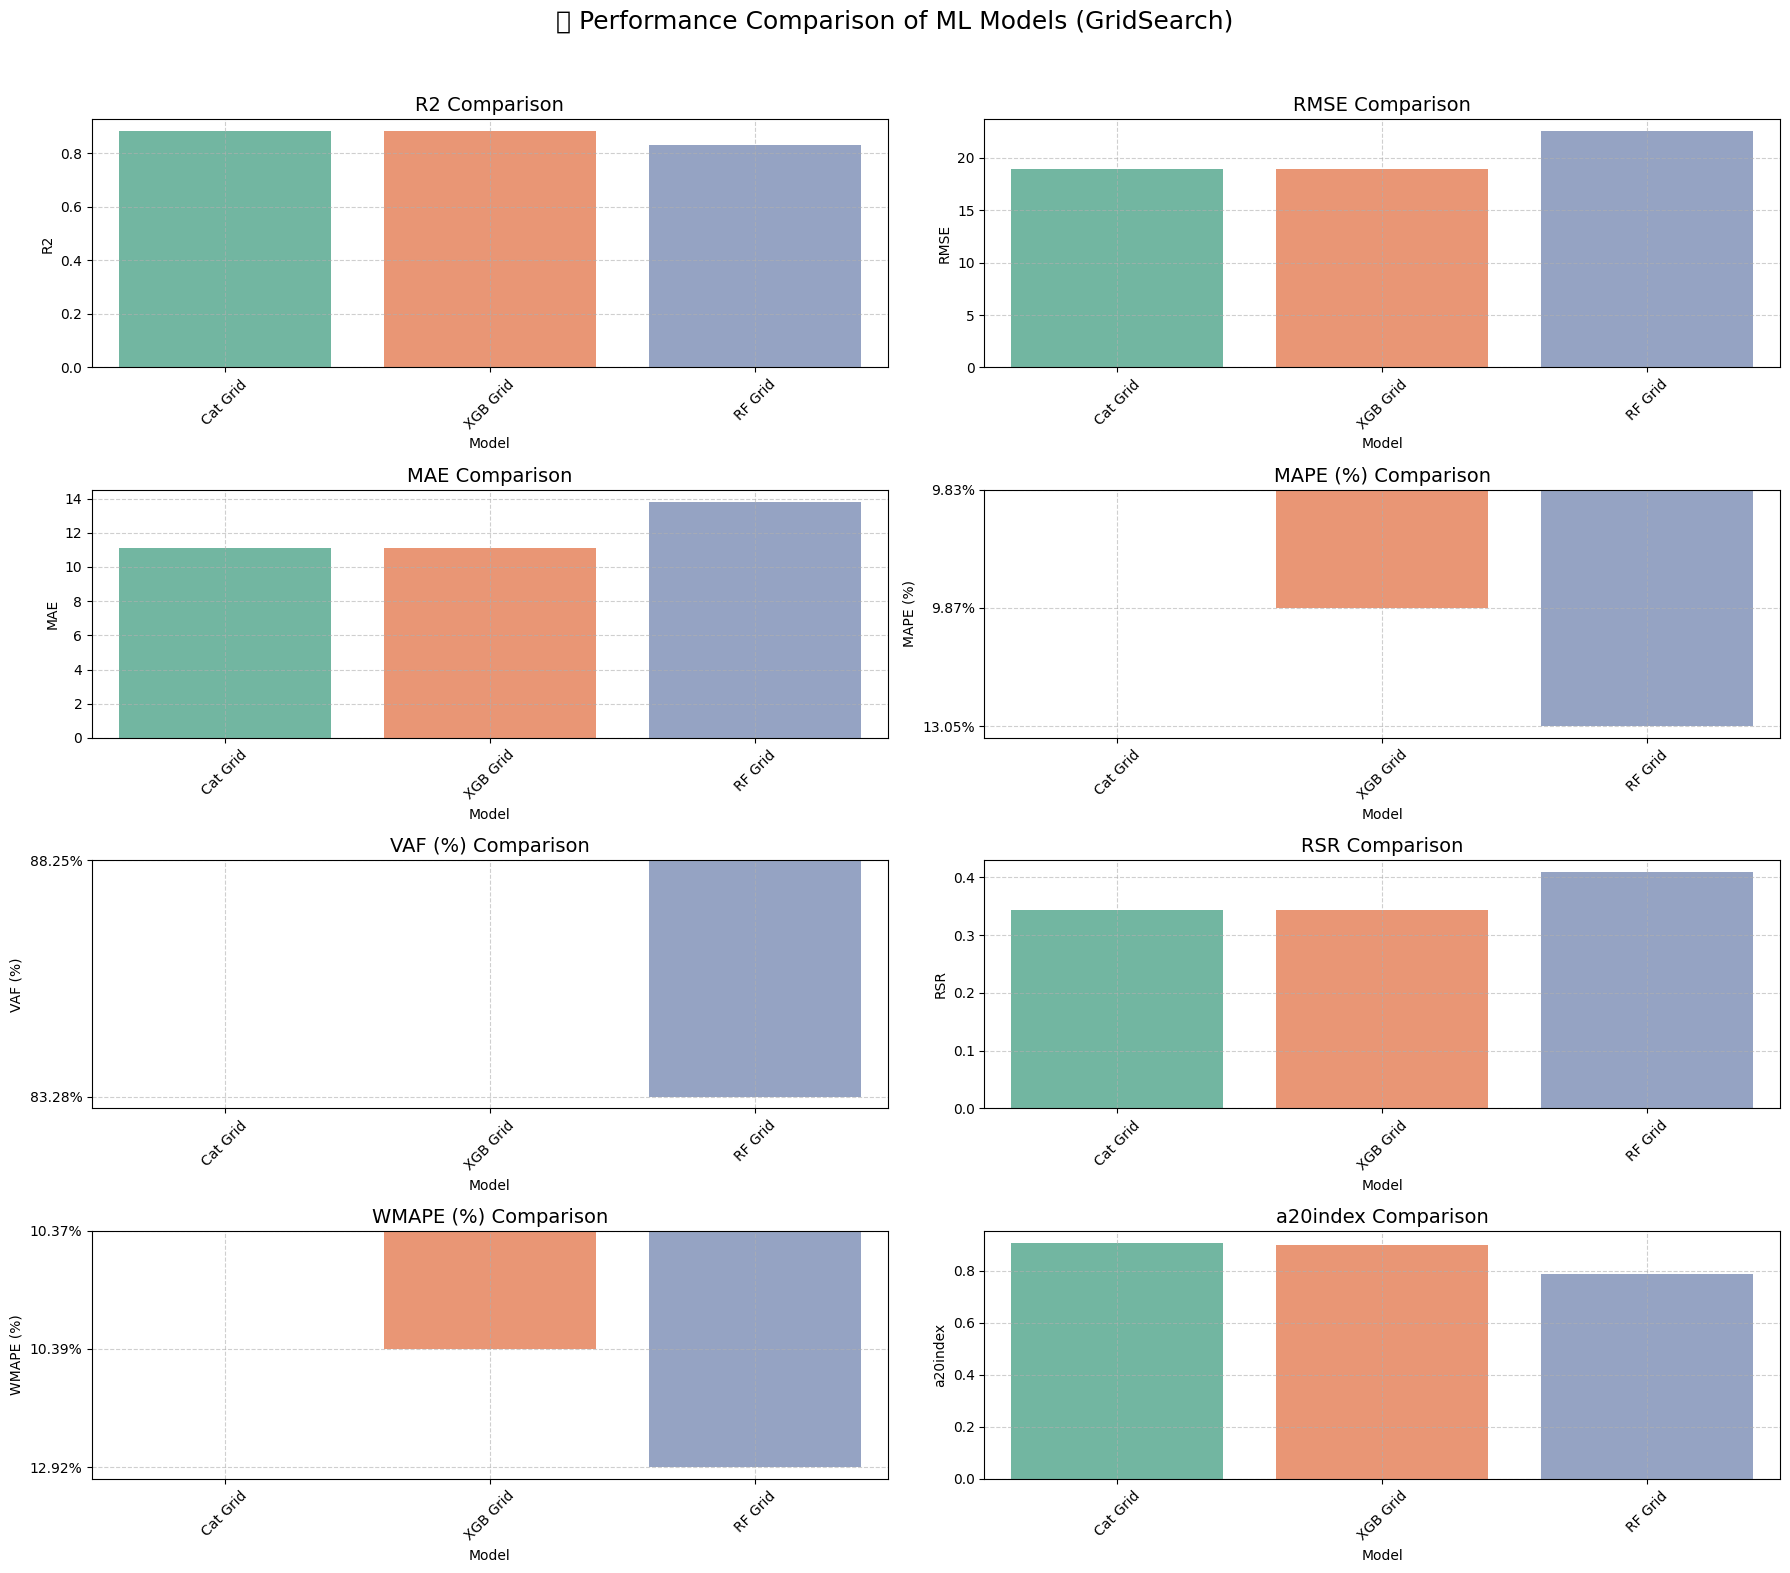

In [10]:
# === 📈 Visual Comparison (Corrected) ===
metrics_list = ["R2", "RMSE", "MAE", "MAPE (%)",
                "VAF (%)", "RSR", "WMAPE (%)", "a20index"]

num_metrics = len(metrics_list)
cols = 2
rows = int(np.ceil(num_metrics / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows
colors = sns.color_palette("Set2", n_colors=len(df_results))

for i, metric in enumerate(metrics_list):
    sns.barplot(data=df_results, x="Model", y=metric, ax=axes[i], palette=colors)
    axes[i].set_title(f"{metric} Comparison", fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle='--', alpha=0.6)

# Hide unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("📊 Performance Comparison of ML Models (GridSearch)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
